# Dojo Green AI : Notebook brouillon

In [26]:
import codecarbon
from codecarbon import EmissionsTracker
import time
import numpy as np
import sklearn
import pandas as pd

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor


import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

RANDOM_SEED = 415915
np.random.seed(RANDOM_SEED)

# Load the dataset

In [27]:
dataset = pd.read_csv(
    "/Users/camille.hascoet/Documents/greenai/src/hale/data/mars-2014-complete.csv",
    sep=";",
)  # type: pd.DataFrame # Load the dataset

dataset = dataset.dropna()  # Drop rows with missing values

target = "co2"  # type: str # Define the target variable

# Look for features to remove

In [28]:
y = dataset[target]  # type: pd.Series # Define the target variable
X = dataset.drop(columns=[target])  # type: pd.DataFrame # Define the features

var_num = X.select_dtypes(
    include=[float, int]
).columns.to_list()  # type: List[str] # Define the numerical features
var_cat = X.select_dtypes(
    include=[object]
).columns.to_list()  # type: List[str] # Define the categorical features

In [29]:
corr_matrix = dataset.drop(
    columns=var_cat
).corr()  # type: pd.DataFrame # Compute the correlation matrix

print(corr_matrix[target].sort_values(ascending=False))  # Print the correlation matrix

var_num.remove("nox")  # Remove the 'nox' feature
var_num.remove("ptcl")  # Remove the 'ptcl' feature

co2                1.000000
conso_mixte        0.999561
conso_exurb        0.995416
conso_urb          0.994763
puiss_admin_98     0.944656
masse_ordma_max    0.925491
masse_ordma_min    0.898020
nox               -0.046806
hcnox             -0.325448
hc                -0.790523
co_typ_1          -0.942465
ptcl                    NaN
Name: co2, dtype: float64


In [30]:
cardinality = X[
    var_cat
].nunique()  # type: pd.Series # Compute the cardinality of the categorical features

low_cardinality = cardinality[
    cardinality <= 10
].index.to_list()  # type: List[str] # Select the categorical features with low cardinality

X.drop(
    X.columns.difference(var_num + low_cardinality), axis=1, inplace=True
)  # Keep only the selected features

# Create pipeline + separate train & test data

In [31]:
numerical_pipeline = make_pipeline(
    StandardScaler()
)  # type: Pipeline # Define the numerical pipeline

categorical_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore")
)  # type: Pipeline # Define the categorical pipeline # handle_unknown='ignore' is used to ignore unknown categories in the test set

preprocessor = make_column_transformer(
    (numerical_pipeline, var_num),
    (categorical_pipeline, low_cardinality),
    remainder="drop",
)  # type: ColumnTransformer # Define the preprocessor

y_scaler = StandardScaler()  # type: StandardScaler # Define the target variable scaler
y = y_scaler.fit_transform(
    y.values.reshape(-1, 1)
).flatten()  # Scale the target variable

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)  # Split the dataset into a training and a test set

X_train = preprocessor.fit_transform(X_train)  # Preprocess the training set
X_test = preprocessor.transform(X_test)  # Preprocess the test set

# Model Selection : Green vs Red

## Part I : Naive training, no hyper-parameters

In [32]:
def train_model(
    model: sklearn.base.BaseEstimator, X_train: np.ndarray, y_train: np.ndarray
) -> tuple[sklearn.base.BaseEstimator, float]:
    """
    Train a model on the training set

    Parameters
    ----------
    model : sklearn.base.BaseEstimator
        The model to train
    X_train : np.ndarray
        The training set
    y_train : np.ndarray
        The target variable of the training set

    Returns
    -------
    sklearn.base.BaseEstimator
        The trained model
    """
    tracker = EmissionsTracker(
        log_level="critical", save_to_file=False
    )  # type: EmissionsTracker # Create an emissions tracker
    tracker.start()  # Start the emissions tracker
    model.fit(X_train, y_train)  # Train the model
    emissions = tracker.stop()  # Stop the emissions tracker
    return (
        model,
        emissions * 1000,
    )  # Return the trained model and the emissions in gCO2eq

In [33]:
models = [
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    MLPRegressor(hidden_layer_sizes=(300, 100, 50, 30)),
    LinearRegression(),
    LGBMRegressor(),
]  # type: List[sklearn.base.BaseEstimator] # Define the models

models_names = [
    "RF",
    "GB",
    "SVR",
    "MLP",
    "LR",
    "LGBM",
]  # type: List[str] # Define the names of the

trained_models = (
    {}
)  # type: Dict[str, sklearn.base.BaseEstimator] # Create a dictionary to store the trained models

results = pd.DataFrame(
    columns=["Model", "Emissions"]
)  # type: pd.DataFrame # Create a DataFrame to store the results

for model, model_name in zip(models, models_names):
    model, emissions = train_model(model, X_train, y_train)  # Train the model
    trained_models[model_name] = model  # Store the trained model
    results = pd.concat(
        [
            results,
            pd.DataFrame([[model_name, emissions]], columns=["Model", "Emissions"]),
        ]
    )  # Store the results

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 28, number of used features: 0
[LightGBM] [Info] Start training from score -0.010475
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

In [34]:
print(results)

  Model     Emissions
0    RF  5.072385e-05
0    GB  1.402610e-05
0   SVR  4.417964e-07
0   MLP  2.213005e-05
0    LR  5.606237e-07
0  LGBM  2.492995e-06


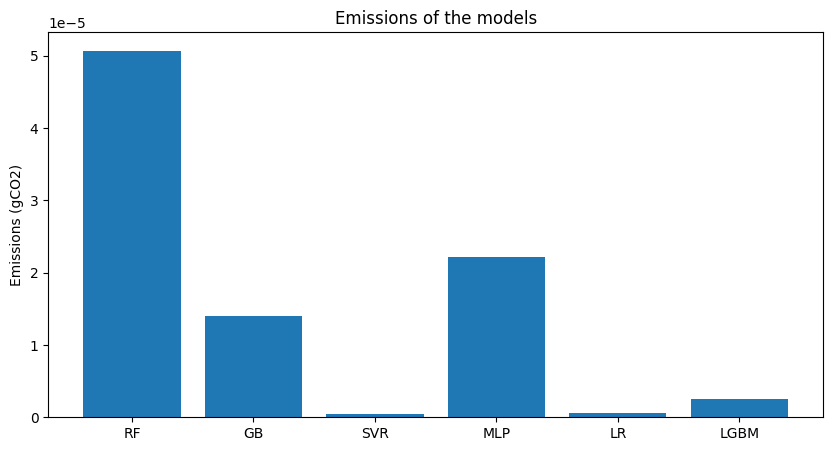

In [35]:
# Plot the results, barplot
plt.figure(figsize=(10, 5))
plt.bar(results["Model"], results["Emissions"])
plt.ylabel("Emissions (gCO2)")
plt.title("Emissions of the models")
plt.show()

## Evaluate models, inference emissions & compare them altogether

In [36]:
def predict(
    model: sklearn.base.BaseEstimator, X_test: np.ndarray, y_test: np.ndarray
) -> tuple[float, float]:
    """
    Compute the predictions of the model and its performance on the test set

    Parameters
    ----------
    model : sklearn.base.BaseEstimator
        The model
    X_test : np.ndarray
        The test set
    y_test : np.ndarray
        The target variable of the test set

    Returns
    -------
    np.ndarray
        The predictions of the model
    float
        The performance of the model
    """
    tracker = EmissionsTracker(
        log_level="critical", save_to_file=False
    )  # type: EmissionsTracker # Create an emissions tracker
    tracker.start()  # Start the emissions tracker
    y_pred = model.predict(X_test)  # Compute the predictions
    emissions = tracker.stop()  # Stop the emissions tracker
    performance = sklearn.metrics.r2_score(y_test, y_pred)  # Compute the performance
    return performance, emissions * 1000 / len(
        y_test
    )  # Return the performance and the emissions in gCO2eq

In [37]:
# Compute the predictions and the performance of the models

results_performance = pd.DataFrame(
    columns=["Model", "Performance", "Inference Emissions"]
)  # type: pd.DataFrame # Create a DataFrame to store the results

for model, model_name in zip(models, models_names):
    performance, emissions = predict(
        model, X_test, y_test
    )  # Compute the predictions and the performance
    results_performance = pd.concat(
        [
            results_performance,
            pd.DataFrame(
                [[model_name, performance, emissions]],
                columns=["Model", "Performance", "Inference Emissions"],
            ),
        ]
    )  # Store the results

In [38]:
print(results_performance)

  Model  Performance  Inference Emissions
0    RF     0.995513         3.065606e-07
0    GB     0.995506         3.951504e-08
0   SVR     0.970252         4.234623e-08
0   MLP     0.981917         4.225708e-08
0    LR     0.980031         3.526185e-08
0  LGBM    -0.007496         1.145486e-07


## Scatter plot of the model's inference emissions over performance

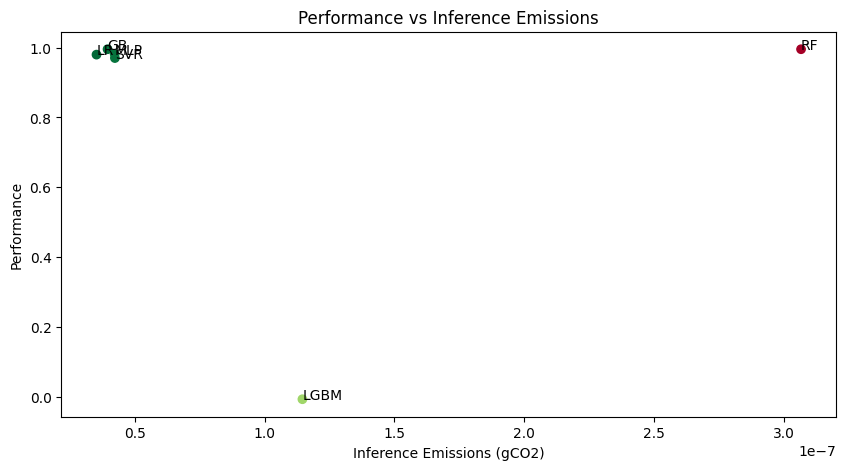

In [39]:
plt.figure(figsize=(10, 5))
inference_emissions = results_performance["Inference Emissions"].to_numpy()
performance = results_performance["Performance"].to_numpy()
# color from green to red depending on inference emissions
plt.scatter(inference_emissions, performance, c=inference_emissions, cmap="RdYlGn_r")
for i, txt in enumerate(models_names):
    plt.annotate(
        txt, (inference_emissions[i], performance[i])
    )  # Add the name of the model next to the point
plt.xlabel("Inference Emissions (gCO2)")
plt.ylabel("Performance")
plt.title("Performance vs Inference Emissions")
plt.show()

## Same scatter plot but this time the color map will be the 3rd dimensions for the training emissions

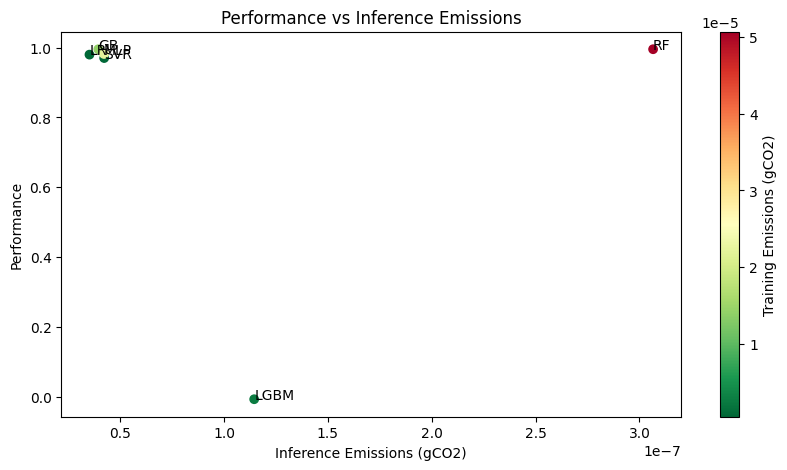

In [40]:
## Same scatter plot but this time the color map will be the 3rd dimensions for the training emissions
training_emissions = results["Emissions"].to_numpy()
plt.figure(figsize=(10, 5))
plt.scatter(
    inference_emissions,
    performance,
    c=training_emissions,
    cmap="RdYlGn_r",
)
for i, txt in enumerate(models_names):
    plt.annotate(
        txt, (inference_emissions[i], performance[i])
    )  # Add the name of the model next to the point
plt.xlabel("Inference Emissions (gCO2)")
plt.ylabel("Performance")
plt.title("Performance vs Inference Emissions")
# add colorbar
# add label to the colorbar
plt.colorbar().set_label("Training Emissions (gCO2)")
plt.show()

# Hyper-parameter tuning : Green vs Red

## *Laisser le choix du modèle aux participants et appliquer random/grid*

In [41]:
chosen_model = trained_models[
    "GB"
]  # type: sklearn.base.BaseEstimator # Select the model with the performance / emissions trade-off we want

parameters_grid_small = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 1],
}  # type: Dict[str, List[Union[int, float]]] # Define the grid of hyperparameters

parameters_grid_medium = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    "max_depth": [3, 5, 7, 9, 11],
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1],
}  # type: Dict[str, List[Union[int, float]]] # Define the grid of hyperparameters

parameters_grid_large = {
    "n_estimators": [50, 100, 150, 200, 250, 300, 350, 400],
    "max_depth": [3, 5, 7, 9, 11, 13, 15],
    "learning_rate": [0.01, 0.03, 0.05, 0.07, 0.1, 0.3, 0.5, 1],
    "criterion": ["squared_error", "friedman_mse"],
}  # type: Dict[str, List[Union[int, float]]] # Define the grid of hyperparameters

## Create the functions to tune the hyper-parameters & calculating emissions

In [42]:
def tune_hyperparameters(
    model: sklearn.base.BaseEstimator,
    search_method: str,
    parameters_grid: dict,
    X_train: np.ndarray,
    y_train: np.ndarray,
) -> sklearn.base.BaseEstimator:
    """
    Tune the hyperparameters of a model

    Parameters
    ----------
    model : sklearn.base.BaseEstimator
        The model
    search_method : str
        The search method ('grid' or 'random')
    parameters_grid : dict
        The grid of hyperparameters
    X_train : np.ndarray
        The training set
    y_train : np.ndarray
        The target variable of the training set

    Returns
    -------
    sklearn.base.BaseEstimator
        The model with the tuned hyperparameters
    """
    tracker = EmissionsTracker(
        log_level="critical", save_to_file=False
    )  # type: EmissionsTracker # Create an emissions tracker
    if search_method == "grid":
        search = GridSearchCV(
            model, parameters_grid, scoring="r2", cv=5
        )  # type: GridSearchCV # Create a grid search
    elif search_method == "random":
        search = RandomizedSearchCV(
            model, parameters_grid, scoring="r2", cv=5
        )  # type: RandomizedSearchCV # Create a randomized search
    tracker.start()  # Start the emissions tracker
    search.fit(X_train, y_train)  # Fit the search
    emissions = tracker.stop()  # Stop the emissions tracker
    return (
        search.best_estimator_,
        emissions * 1000,
    )  # Return the model with the tuned hyperparameters and the emissions in gCO2eq

In [43]:
chosen_model_grid_small, emissions_grid_small = tune_hyperparameters(
    chosen_model, "grid", parameters_grid_small, X_train, y_train
)  # Tune the hyperparameters of the chosen model with the small grid using grid search
chosen_model_rand_small, emissions_rand_small = tune_hyperparameters(
    chosen_model, "random", parameters_grid_small, X_train, y_train
)  # Tune the hyperparameters of the chosen model with the small grid using random search

In [44]:
chosen_model_grid_medium, emissions_grid_medium = tune_hyperparameters(
    chosen_model, "grid", parameters_grid_medium, X_train, y_train
)  # Tune the hyperparameters of the chosen model with the medium grid using grid search
chosen_model_rand_medium, emissions_rand_medium = tune_hyperparameters(
    chosen_model, "random", parameters_grid_medium, X_train, y_train
)  # Tune the hyperparameters of the chosen model with the medium grid using random search

ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


In [45]:
chosen_model_grid_large, emissions_grid_large = tune_hyperparameters(
    chosen_model, "grid", parameters_grid_large, X_train, y_train
)  # Tune the hyperparameters of the chosen model with the large grid using grid search
chosen_model_rand_large, emissions_rand_large = tune_hyperparameters(
    chosen_model, "random", parameters_grid_large, X_train, y_train
)  # Tune the hyperparameters of the chosen model with the large grid using random search

ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc


In [49]:
results_search = pd.DataFrame(
    columns=["Model", "Emissions", "Performance"]
)  # type: pd.DataFrame # Create a DataFrame to store the results : performance over search emissions

search_names = [
    "Grid Small",
    "Random Small",
    "Grid Medium",
    "Random Medium",
    "Grid Large",
    "Random Large",
]  # type: List[str] # Define the names of the search methods

for i, (model, emissions) in enumerate(
    [
        (chosen_model_grid_small, emissions_grid_small),
        (chosen_model_rand_small, emissions_rand_small),
        (chosen_model_grid_medium, emissions_grid_medium),
        (chosen_model_rand_medium, emissions_rand_medium),
        (chosen_model_grid_large, emissions_grid_large),
        (chosen_model_rand_large, emissions_rand_large),
    ]
):
    performance, _ = predict(
        model, X_test, y_test
    )  # Compute the predictions and the performance
    results_search = pd.concat(
        [
            results_search,
            pd.DataFrame(
                [[search_names[i], emissions, performance]],
                columns=["Model", "Emissions", "Performance"],
            ),
        ]
    )  # Store the results

In [50]:
print(results_search)

           Model  Emissions  Performance
0     Grid Small   0.004816     0.999819
0   Random Small   0.001799     0.998496
0    Grid Medium   0.029672     0.999999
0  Random Medium   0.001428     0.994889
0     Grid Large   0.179578     0.994019
0   Random Large   0.001129     0.997600


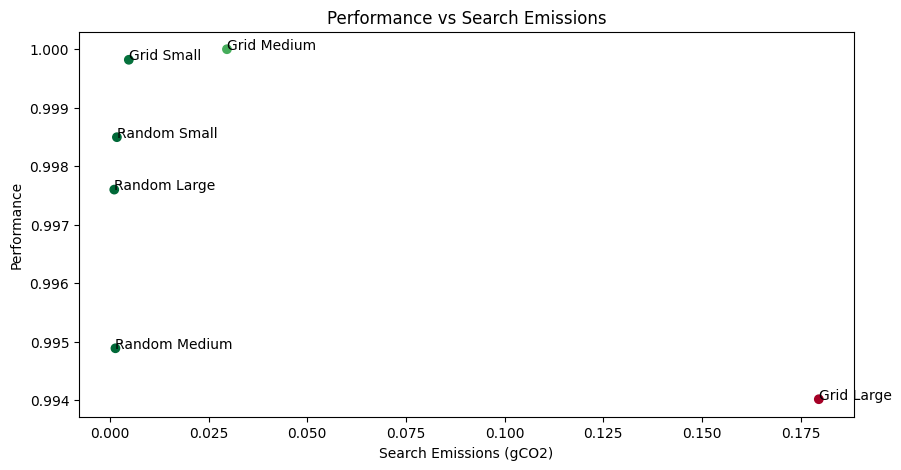

In [52]:
# scatter plot
plt.figure(figsize=(10, 5))
emissions_search = results_search["Emissions"].to_numpy()
performance_search = results_search["Performance"].to_numpy()
grid_names = results_search["Model"].to_numpy()

plt.scatter(
    emissions_search,
    performance_search,
    c=emissions_search,
    cmap="RdYlGn_r",
)

for i, txt in enumerate(grid_names):
    plt.annotate(
        txt, (emissions_search[i], performance_search[i])
    )  # Add the name of the model next to the point

plt.xlabel("Search Emissions (gCO2)")
plt.ylabel("Performance")
plt.title("Performance vs Search Emissions")
plt.show()